In [1]:
import sys
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append(".")
# os.environ["MAX_JOBS"] = "100"

import torch
torch.set_printoptions(linewidth=200, threshold=100000)
torch.cuda.is_available()

from tqdm import tqdm
import matplotlib.pyplot as plt
from plot_utils import plot_numerical_diffs

In [2]:
from src.vlstm_fwbw_v1.interface import vlstm_fwbw_torch_autogradbw
from src.vlstm_fwbw_v1.interface import vlstm_fw_torch, vlstm_fw_cuda
from src.vlstm_fwbw_v1.interface import vlstm_bw_torch_obw, vlstm_bw_cuda

INCLUDE: ['/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/torch/csrc/api/include', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/TH', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/THC', '/home/max/miniconda3/envs/xlstmpt220cu121/include']
/home/max/myrepos/vlstm_cuda/src
/home/max/cpplibs/libtorch/lib:/usr/local/cuda-12.3/lib64:
/home/max/miniconda3/envs/xlstmpt220cu121/lib


Using /home/max/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/max/.cache/torch_extensions/py311_cu121/vlstm_fwbw_v1/build.ninja...
Building extension module vlstm_fwbw_v1...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/2] /home/max/miniconda3/envs/xlstmpt220cu121/bin/nvcc --generate-dependencies-with-compile --dependency-output kernel_fw.cuda.o.d -ccbin /home/max/miniconda3/envs/xlstmpt220cu121/bin/x86_64-conda-linux-gnu-cc -DTORCH_EXTENSION_NAME=vlstm_fwbw_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/torch/csrc/api/include -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/TH -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/THC -isystem /home/max/miniconda3/envs/xlstmpt220cu121/include -isystem /home/max/miniconda3/envs/xlstmpt220cu121/include/python3.11 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERS

Loading extension module vlstm_fwbw_v1...


## CUDA vLSTM forward-backward 

Choose large tile sizes.

### Get gpu_info

In [3]:
from src.gpu_info.gpu_info import get_gpu_info

In [4]:
get_gpu_info(0)

Using /home/max/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/max/.cache/torch_extensions/py311_cu121/gpu_info2/build.ninja...
Building extension module gpu_info2...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module gpu_info2...


{'name': 'NVIDIA GeForce RTX 4060 Laptop GPU',
 'luid': '',
 'luidDeviceNodeMask': 0,
 'totalGlobalMem': 8325824512,
 'sharedMemPerBlock': 49152,
 'regsPerBlock': 65536,
 'warpSize': 32,
 'memPitch': 2147483647,
 'maxThreadsPerBlock': 1024,
 'maxThreadsDim[0]': 1024,
 'maxThreadsDim[1]': 1024,
 'maxThreadsDim[2]': 64,
 'maxGridSize[0]': 2147483647,
 'maxGridSize[1]': 65535,
 'maxGridSize[2]': 65535,
 'clockRate': 2250000,
 'totalConstMem': 65536,
 'major': 8,
 'minor': 9,
 'textureAlignment': 512,
 'texturePitchAlignment': 32,
 'deviceOverlap': 1,
 'multiProcessorCount': 24,
 'kernelExecTimeoutEnabled': 1,
 'integrated': 0,
 'canMapHostMemory': 1,
 'computeMode': 0,
 'maxTexture1D': 131072,
 'maxTexture1DMipmap': 32768,
 'maxTexture1DLinear': 268435456,
 'maxTexture2D': 131072,
 'maxTexture2DMipmap': 32768,
 'maxTexture2DLinear': 131072,
 'maxTexture2DGather': 32768,
 'maxTexture3D': 16384,
 'maxTexture3DAlt': 8192,
 'maxTextureCubemap': 32768,
 'maxTexture1DLayered': 32768,
 'maxTextu

### define inputs

In [5]:
S = 128 #32 #32 #16 #8 # seq len
B = 1 # batch size
NH = 1 # num heads
DH = 32 # dim per head
DTYPE = torch.float32
DEVICE = torch.device("cuda:0")

In [6]:
# create qkv, inputgates, forgetgates 
torch.manual_seed(0)
# fixed:
# qs = torch.arange((B*NH*S*DH), device=DEVICE, dtype=DTYPE).reshape((B, NH, S, DH)) / 10.
# ks = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# vs = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.

# random: 
qs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
ks = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
vs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# igs = (1. + torch.arange((B * NH * S), device=DEVICE, dtype=DTYPE)).reshape(B, NH, S, 1) / 10.
# igs = torch.zeros((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
igs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
# fgs = torch.ones((B, NH, S, 1), device=DEVICE, dtype=DTYPE)
fgs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE)

dHs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)

In [7]:
# inputs float16
dtype_fp16 = torch.float16
qs_half = qs.to(dtype=dtype_fp16)
ks_half = ks.to(dtype=dtype_fp16)
vs_half = vs.to(dtype=dtype_fp16)
igs_half = igs.to(dtype=dtype_fp16)
fgs_half = fgs.to(dtype=dtype_fp16)
dHs_half = dHs.to(dtype=dtype_fp16)

In [8]:
# inputs bfloat16
dtype_bf16 = torch.bfloat16
qs_bf16 = qs.to(dtype=dtype_bf16)
ks_bf16 = ks.to(dtype=dtype_bf16)
vs_bf16 = vs.to(dtype=dtype_bf16)
igs_bf16 = igs.to(dtype=dtype_bf16)
fgs_bf16 = fgs.to(dtype=dtype_bf16)
dHs_bf16 = dHs.to(dtype=dtype_bf16)

### compare errors pure pytorch

In [9]:
hs_pt, n_pt, m_pt, _, matD_pt = vlstm_fw_torch(queries=qs, keys=ks, values=vs, igate_preact=igs, fgate_preact=fgs)
dQs_pt, dKs_pt, dVs_pt, dIgs_pt, dFgs_pt, delta_D_pt, delta_Dtilde_pt, delta_fbar_pt, mat_P_pt, mat_R_pt = vlstm_bw_torch_obw(
    delta_Htilde=dHs,
    queries=qs,
    keys=ks,
    values=vs,
    igate_preact=igs,
    fgate_preact=fgs,
    var_n=n_pt,
    var_m=m_pt,
)
dQs_pt.dtype

torch.float32

In [10]:
hs_pt_half, n_pt_half, m_pt_half, _, matD_pt_half = vlstm_fw_torch(queries=qs_half, keys=ks_half, values=vs_half, igate_preact=igs_half, fgate_preact=fgs_half)
dQs_pt_half, dKs_pt_half, dVs_pt_half, dIgs_pt_half, dFgs_pt_half, delta_D_pt_half, delta_Dtilde_pt_half, delta_fbar_pt_half, mat_P_pt_half, mat_R_pt_half = vlstm_bw_torch_obw(
    delta_Htilde=dHs_half,
    queries=qs_half,
    keys=ks_half,
    values=vs_half,
    igate_preact=igs_half,
    fgate_preact=fgs_half,
    var_n=n_pt_half,
    var_m=m_pt_half,
)
dQs_pt_half.dtype, delta_D_pt_half.dtype

(torch.float16, torch.float16)

In [11]:
hs_pt_bf16, n_pt_bf16, m_pt_bf16, _, matD_pt_bf16 = vlstm_fw_torch(queries=qs_bf16, keys=ks_bf16, values=vs_bf16, igate_preact=igs_bf16, fgate_preact=fgs_bf16)
dQs_pt_bf16, dKs_pt_bf16, dVs_pt_bf16, dIgs_pt_bf16, dFgs_pt_bf16, delta_D_pt_bf16, delta_Dtilde_pt_bf16, delta_fbar_pt_bf16, mat_P_pt_bf16, mat_R_pt_bf16 = vlstm_bw_torch_obw(
    delta_Htilde=dHs_bf16,
    queries=qs_bf16,
    keys=ks_bf16,
    values=vs_bf16,
    igate_preact=igs_bf16,
    fgate_preact=fgs_bf16,
    var_n=n_pt_bf16,
    var_m=m_pt_bf16,
)
dQs_pt_bf16.dtype, delta_D_pt_bf16.dtype

(torch.bfloat16, torch.bfloat16)

In [12]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"====== Full -> Half ======")
print(f"fw hs match: {torch.allclose(hs_pt_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_half.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_half.float() - matD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_pt_half.float(), dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_pt_half - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_pt_half.float(), dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_pt_half - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_pt_half.float(), dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_pt_half - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_pt_half.float(), dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_pt_half - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_pt_half.float(), dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_pt_half - dFgs_pt))}")
print(f"bw delta_D match: {torch.allclose(delta_D_pt_half.float(), delta_D_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(delta_D_pt_half - delta_D_pt))}")
print(f"====== Full -> bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_pt_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_bf16.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_bf16.float() - matD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_pt_bf16.float(), dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_pt_bf16 - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_pt_bf16.float(), dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_pt_bf16 - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_pt_bf16.float(), dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_pt_bf16 - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_pt_bf16.float(), dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_pt_bf16 - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_pt_bf16.float(), dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_pt_bf16 - dFgs_pt))}")


====== Full -> Half ======
fw hs match: False, max diff: 0.4708824157714844
fw n match: False, max diff: 0.07867515087127686
fw m match: False, max diff: 0.1912614107131958
fw D match: False, max diff: 0.21427106857299805
---------------------------------
bw dQs match: False, max diff: 0.24714899063110352
bw dKs match: False, max diff: 0.28326165676116943
bw dVs match: False, max diff: 0.2538684606552124
bw dIgs match: False, max diff: 1.4775028228759766
bw dFgs match: False, max diff: 0.5339548587799072
bw delta_D match: False, max diff: 2.0612449645996094
====== Full -> bfloat16 ======
fw hs match: False, max diff: 3.7958269119262695
fw n match: False, max diff: 0.9976204633712769
fw m match: False, max diff: 0.9422379732131958
fw D match: False, max diff: 0.9422379732131958
---------------------------------
bw dQs match: False, max diff: 1.3570556640625
bw dKs match: False, max diff: 1.2744725942611694
bw dVs match: False, max diff: 2.137345314025879
bw dIgs match: False, max diff: 

In [13]:
# (hs_pt_half.float() - hs_pt) #> 4.5e-3

In [14]:
# (hs_pt_bf16.float() - hs_pt) #> 0.018

In [15]:
torch.abs(hs_pt_bf16.float() - hs_pt).max(), torch.abs(hs_pt_bf16.float() - hs_pt).mean() #> 1e-2

(tensor(3.7958, device='cuda:0'), tensor(0.0561, device='cuda:0'))

### match directly

In [16]:
# cuda kernel float32
hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)
dQs_cu, dKs_cu, dVs_cu, dIgs_cu, dFgs_cu, matC_cu = vlstm_bw_cuda(
    mat_delta_H=dHs,
    mat_Q=qs,
    mat_K=ks,
    mat_V=vs,
    vec_igp=igs,
    vec_fgp=fgs,
    vec_n=n_cu,
    vec_m=m_cu,
)

before kernel dispatch - float32!
B: 1, NH: 1, S: 128, DH: 32
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 8736
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 128, DH: 32
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 13024
In BW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In BW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4


In [17]:
# cuda kernel float16
hs_cu_half, n_cu_half, m_cu_half, matD_cu_half = vlstm_fw_cuda(mat_Q=qs_half, mat_K=ks_half, mat_V=vs_half, vec_igp=igs_half, vec_fgp=fgs_half)
dQs_cu_half, dKs_cu_half, dVs_cu_half, dIgs_cu_half, dFgs_cu_half, matC_cu_half = vlstm_bw_cuda(
    mat_delta_H=dHs_half,
    mat_Q=qs_half,
    mat_K=ks_half,
    mat_V=vs_half,
    vec_igp=igs_half,
    vec_fgp=fgs_half,
    vec_n=n_cu_half,
    vec_m=m_cu_half,
)

before kernel dispatch - float16!
B: 1, NH: 1, S: 128, DH: 32
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 4512
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float16!
B: 1, NH: 1, S: 128, DH: 32
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 6656
In BW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In BW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4


In [18]:
# cuda kernel bfloat16
hs_cu_bf16, n_cu_bf16, m_cu_bf16, matD_cu_bf16 = vlstm_fw_cuda(mat_Q=qs_bf16, mat_K=ks_bf16, mat_V=vs_bf16, vec_igp=igs_bf16, vec_fgp=fgs_bf16)
dQs_cu_bf16, dKs_cu_bf16, dVs_cu_bf16, dIgs_cu_bf16, dFgs_cu_bf16, matC_cu_bf16 = vlstm_bw_cuda(
    mat_delta_H=dHs_bf16,
    mat_Q=qs_bf16,
    mat_K=ks_bf16,
    mat_V=vs_bf16,
    vec_igp=igs_bf16,
    vec_fgp=fgs_bf16,
    vec_n=n_cu_bf16,
    vec_m=m_cu_bf16,
)

before kernel dispatch - bfloat16!
B: 1, NH: 1, S: 128, DH: 32
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 4512
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - bfloat16!
B: 1, NH: 1, S: 128, DH: 32
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 6656
In BW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In BW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4


In [19]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"Match against pt float32:")
print(f"====== Full ======")
print(f"fw hs match: {torch.allclose(hs_cu, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu - matD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu - matD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_cu, dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_cu - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_cu, dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_cu - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_cu, dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_cu - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_cu, dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_cu - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_cu, dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_cu - dFgs_pt))}")
print(f"====== Half ======")
print(f"fw hs match: {torch.allclose(hs_cu_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_half.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_half - matD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_cu_half.float(), dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_cu_half - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_cu_half.float(), dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_cu_half - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_cu_half.float(), dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_cu_half - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_cu_half.float(), dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_cu_half - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_cu_half.float(), dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_cu_half - dFgs_pt))}")
print(f"====== bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_cu_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_bf16.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_bf16 - matD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_cu_bf16.float(), dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_cu_bf16 - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_cu_bf16.float(), dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_cu_bf16 - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_cu_bf16.float(), dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_cu_bf16 - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_cu_bf16.float(), dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_cu_bf16 - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_cu_bf16.float(), dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_cu_bf16 - dFgs_pt))}")

Match against pt float32:
====== Full ======
fw hs match: False, max diff: nan
fw n match: True, max diff: 4.7326087951660156e-05
fw m match: True, max diff: 3.552436828613281e-05
fw D match: True, max diff: 1.33514404296875e-05
---------------------------------
bw dQs match: True, max diff: 0.00018644332885742188
bw dKs match: True, max diff: 0.00018548965454101562
bw dVs match: False, max diff: 0.000736236572265625
bw dIgs match: True, max diff: 0.0006694793701171875
bw dFgs match: True, max diff: 0.0002868175506591797
====== Half ======
fw hs match: False, max diff: nan
fw n match: False, max diff: 0.009626388549804688
fw m match: False, max diff: 0.0017533302307128906
fw D match: False, max diff: 0.0372161865234375
---------------------------------
bw dQs match: False, max diff: 0.01279306411743164
bw dKs match: False, max diff: 0.018339157104492188
bw dVs match: False, max diff: 0.016247987747192383
bw dIgs match: False, max diff: 0.02100849151611328
bw dFgs match: False, max diff

In [20]:
# ====== Full -> bfloat16 ======
# fw hs match: False, max diff: 0.15340876579284668
# fw n match: False, max diff: 0.09692215919494629
# fw m match: False, max diff: 0.05207604169845581
# fw D match: False, max diff: 0.15224838256835938
# ---------------------------------
# bw dQs match: False, max diff: 0.13966524600982666
# bw dKs match: False, max diff: 0.13031554222106934
# bw dVs match: False, max diff: 0.09818196296691895
# bw dIgs match: False, max diff: 0.12595558166503906
# bw dFgs match: False, max diff: 0.08353292942047119

### visualize diffs

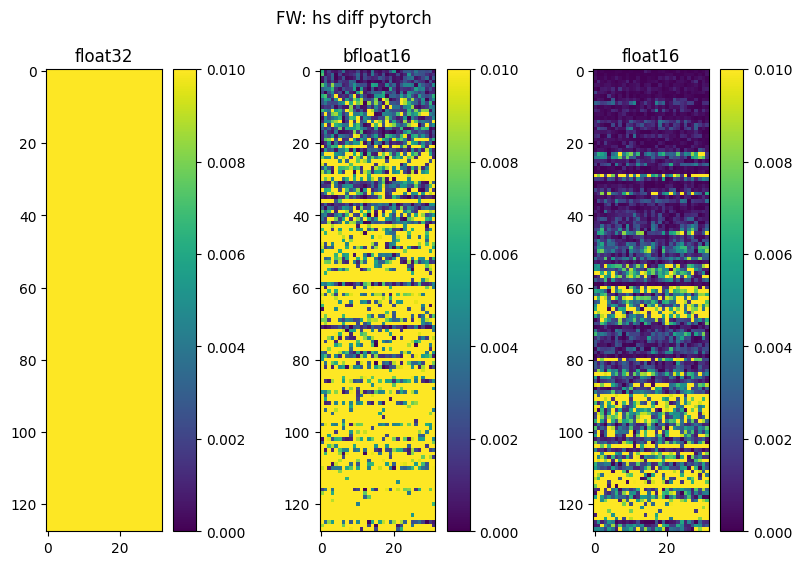

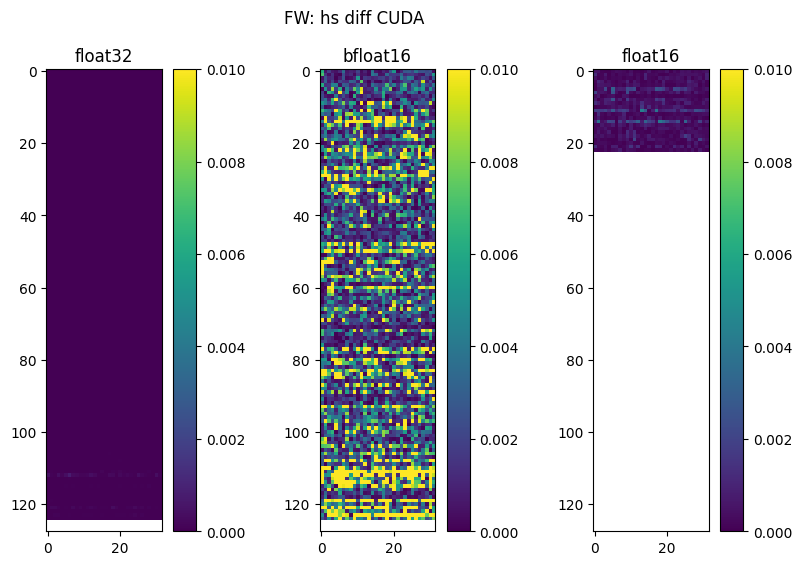

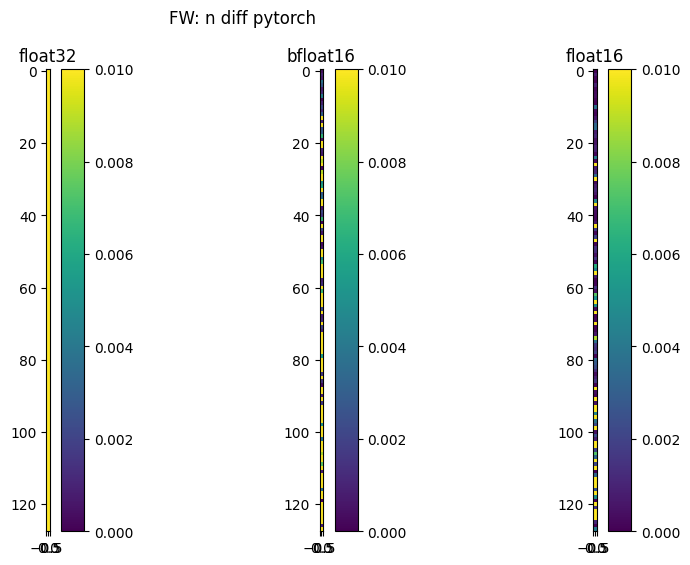

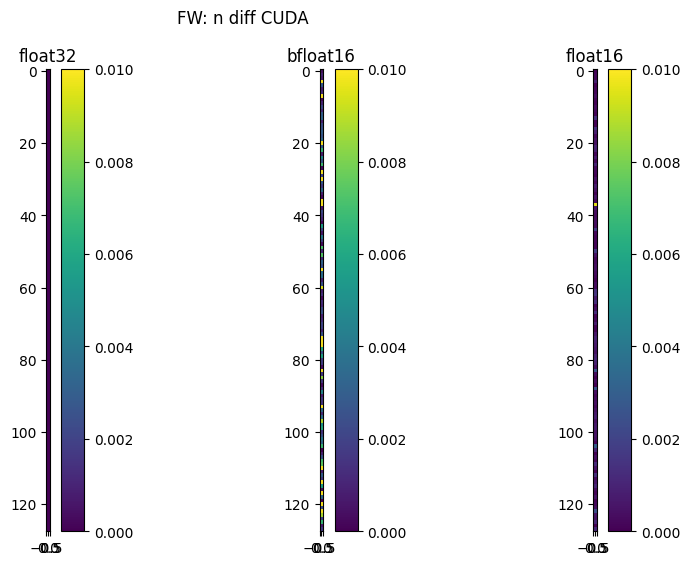

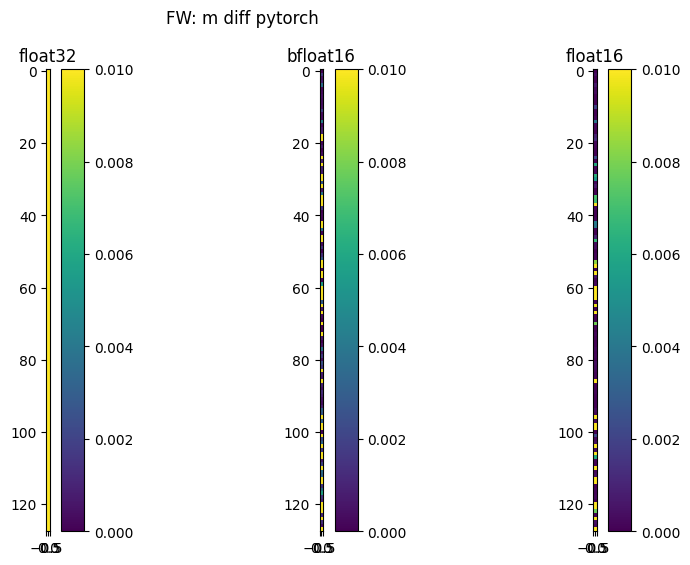

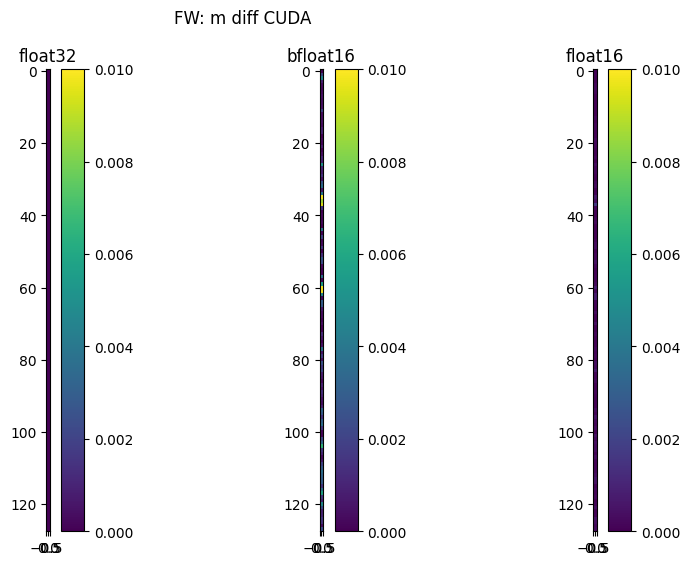

In [21]:
## fw diffs
# hs
fig = plot_numerical_diffs(hs_pt, 10*torch.ones_like(hs_pt), hs_pt_bf16, hs_pt_half, title="FW: hs diff pytorch")
fig = plot_numerical_diffs(hs_pt, hs_cu, hs_cu_bf16, hs_cu_half, title="FW: hs diff CUDA")
# n 
fig = plot_numerical_diffs(n_pt, 10*torch.ones_like(n_pt), n_pt_bf16, n_pt_half, title="FW: n diff pytorch")
fig = plot_numerical_diffs(n_pt, n_cu, n_cu_bf16, n_cu_half, title="FW: n diff CUDA")
# m
fig = plot_numerical_diffs(m_pt, 10*torch.ones_like(m_pt), m_pt_bf16, m_pt_half, title="FW: m diff pytorch")
fig = plot_numerical_diffs(m_pt, m_cu, m_cu_bf16, m_cu_half, title="FW: m diff CUDA")

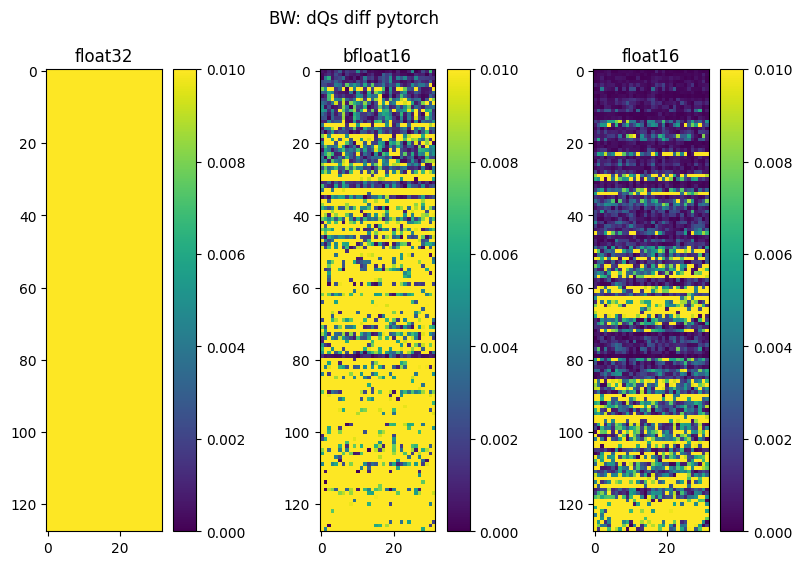

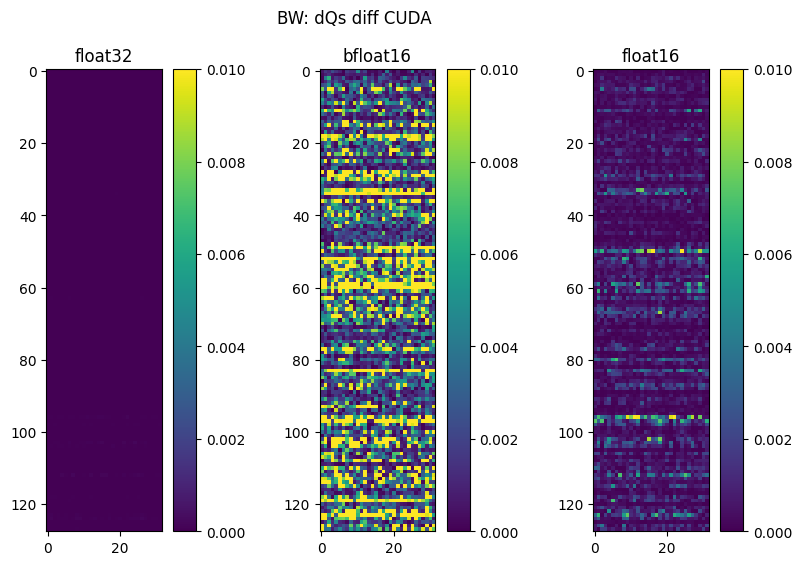

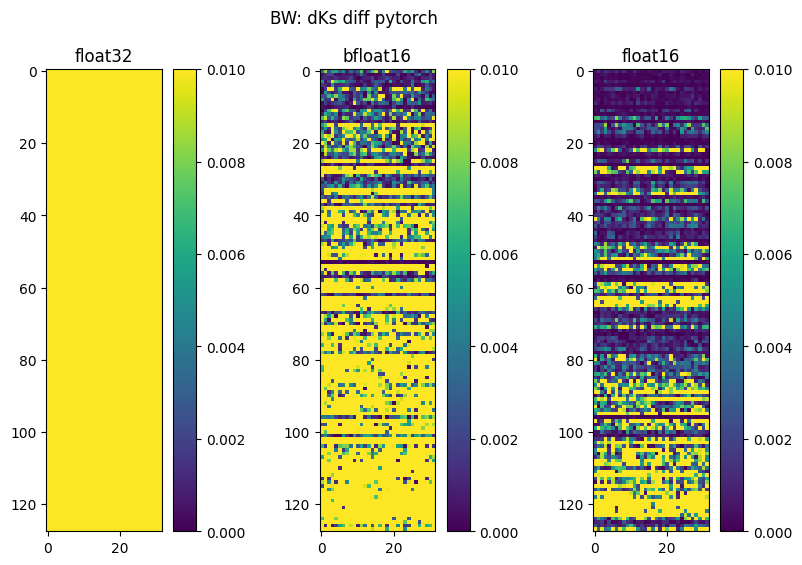

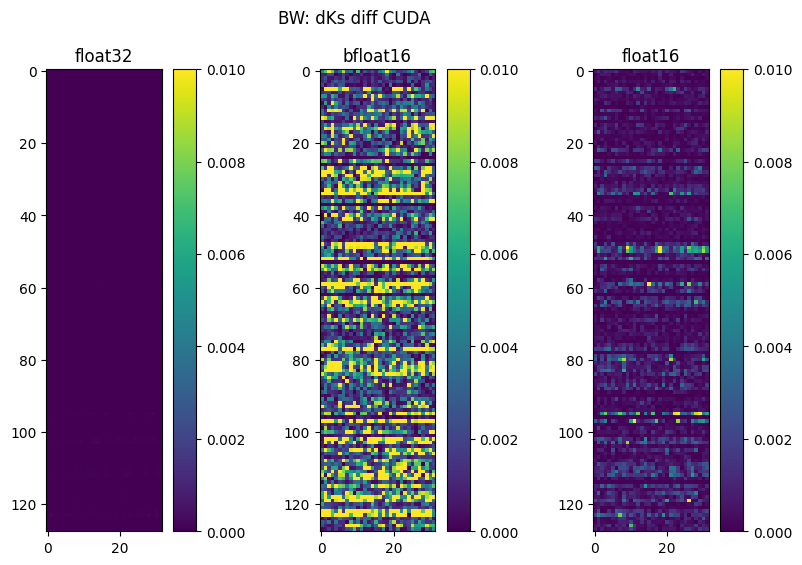

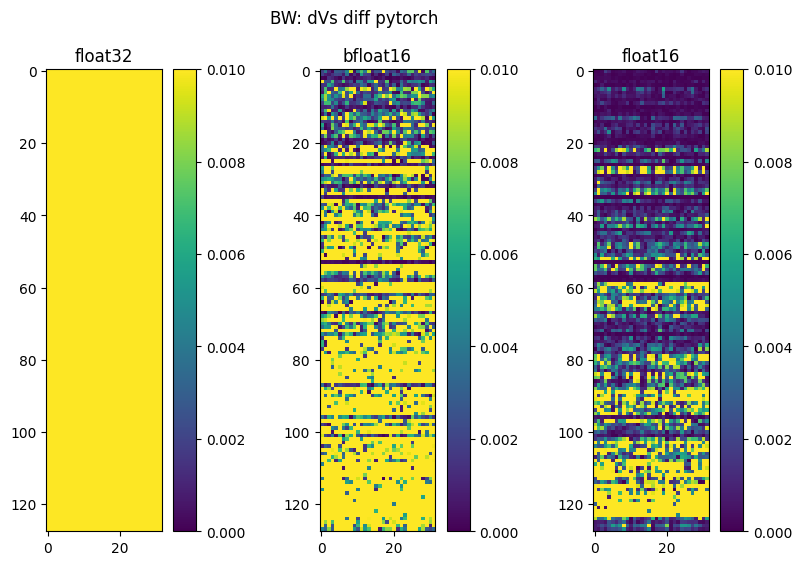

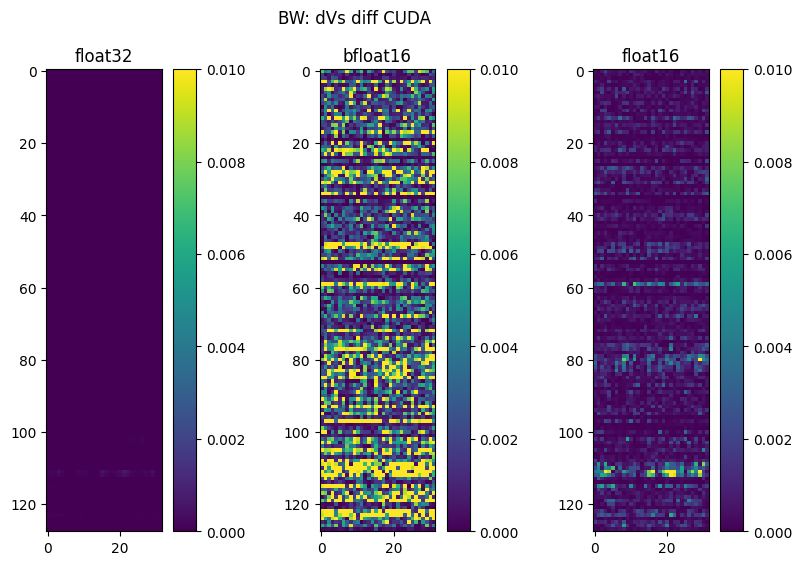

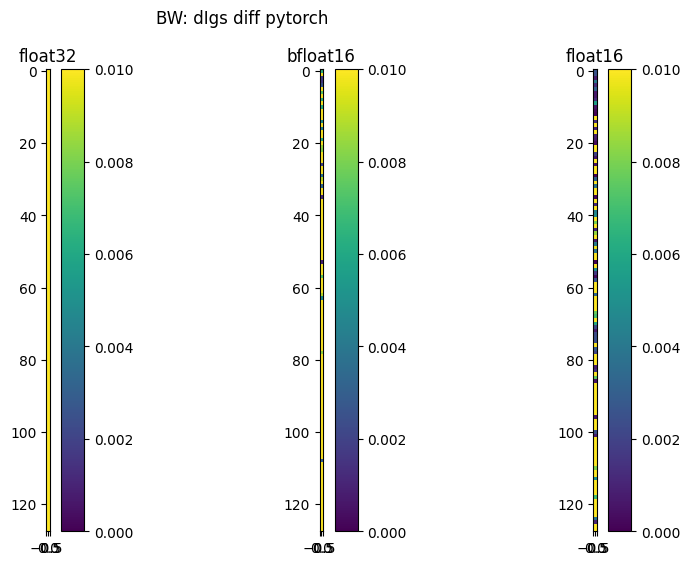

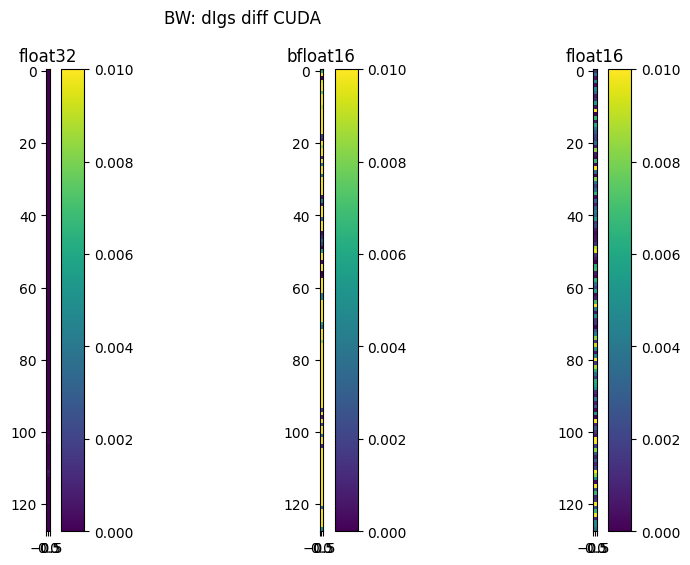

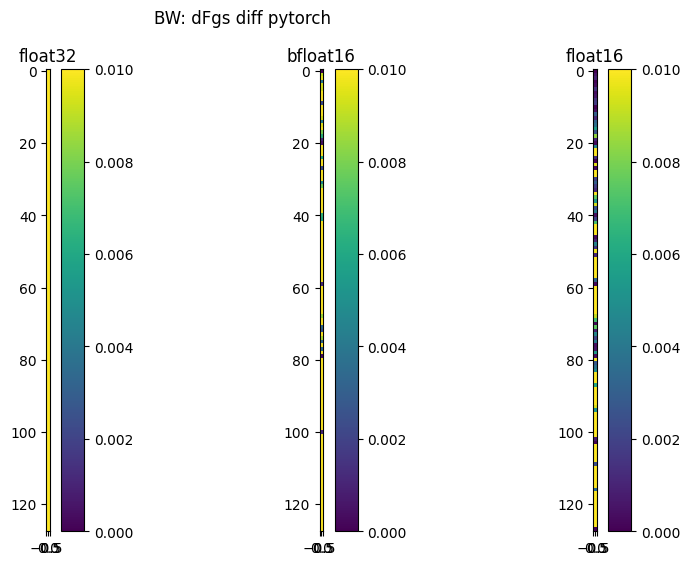

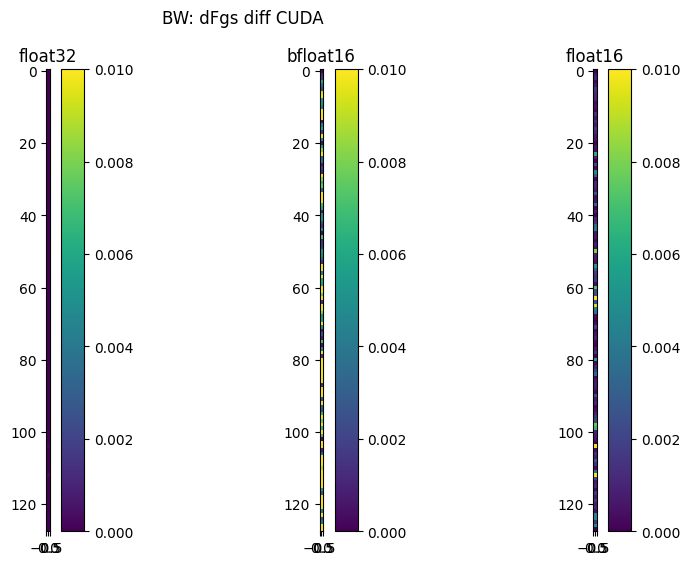

In [22]:
# bw diffs
# dQs
fig = plot_numerical_diffs(dQs_pt, 10*torch.ones_like(dQs_pt), dQs_pt_bf16, dQs_pt_half, title="BW: dQs diff pytorch")
fig = plot_numerical_diffs(dQs_pt, dQs_cu, dQs_cu_bf16, dQs_cu_half, title="BW: dQs diff CUDA")
# dKs
fig = plot_numerical_diffs(dKs_pt, 10*torch.ones_like(dKs_pt), dKs_pt_bf16, dKs_pt_half, title="BW: dKs diff pytorch")
fig = plot_numerical_diffs(dKs_pt, dKs_cu, dKs_cu_bf16, dKs_cu_half, title="BW: dKs diff CUDA")
# dVs
fig = plot_numerical_diffs(dVs_pt, 10*torch.ones_like(dVs_pt), dVs_pt_bf16, dVs_pt_half, title="BW: dVs diff pytorch")
fig = plot_numerical_diffs(dVs_pt, dVs_cu, dVs_cu_bf16, dVs_cu_half, title="BW: dVs diff CUDA")
# dIgs
fig = plot_numerical_diffs(dIgs_pt, 10*torch.ones_like(dIgs_pt), dIgs_pt_bf16, dIgs_pt_half, title="BW: dIgs diff pytorch")
fig = plot_numerical_diffs(dIgs_pt, dIgs_cu, dIgs_cu_bf16, dIgs_cu_half, title="BW: dIgs diff CUDA")
# dFgs
fig = plot_numerical_diffs(dFgs_pt, 10*torch.ones_like(dFgs_pt), dFgs_pt_bf16, dFgs_pt_half, title="BW: dFgs diff pytorch")
fig = plot_numerical_diffs(dFgs_pt, dFgs_cu, dFgs_cu_bf16, dFgs_cu_half, title="BW: dFgs diff CUDA")

### Debug float16 precision differences in cuda kernel

In [23]:
# float32 just for reference
hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)

before kernel dispatch - float32!
B: 1, NH: 1, S: 128, DH: 32
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 8736
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4


In [24]:
fgs

tensor([[[[-0.3452],
          [ 0.6273],
          [ 0.5715],
          [-0.2855],
          [ 0.0376],
          [-1.0302],
          [ 0.2798],
          [ 0.6482],
          [-0.1680],
          [ 1.4557],
          [ 0.3507],
          [-0.2681],
          [-1.6061],
          [ 0.1889],
          [ 1.5553],
          [ 0.8632],
          [ 0.2511],
          [ 1.5612],
          [ 0.1944],
          [ 1.0240],
          [ 2.7869],
          [-1.6915],
          [-1.5141],
          [-0.9227],
          [ 0.6384],
          [-0.1794],
          [-0.8373],
          [ 0.4736],
          [-0.1740],
          [ 0.3401],
          [ 0.1774],
          [-0.1441],
          [ 0.8353],
          [-0.1719],
          [-0.7194],
          [ 0.0260],
          [-0.4151],
          [-1.9766],
          [ 0.2482],
          [ 0.5482],
          [-0.6688],
          [ 0.3455],
          [ 1.3882],
          [-1.2472],
          [ 0.1752],
          [ 1.5941],
          [-0.7804],
          [ 1

In [25]:
hs_cu_half, n_cu_half, m_cu_half, matD_cu_half = vlstm_fw_cuda(mat_Q=qs_half, mat_K=ks_half, mat_V=vs_half, vec_igp=igs_half, vec_fgp=fgs_half)

before kernel dispatch - float16!
B: 1, NH: 1, S: 128, DH: 32
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 4512
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4


In [26]:
print(f"====== Half ======")
print(f"fw hs match: {torch.allclose(hs_cu_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_half.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_half - matD_pt).tril())}")

====== Half ======
fw hs match: False, max diff: nan
fw n match: False, max diff: 0.009626388549804688
fw m match: False, max diff: 0.0017533302307128906
fw D match: False, max diff: 0.0372161865234375


In [27]:
# matS = (qs @ ks.transpose(-2, -1) / (DH ** 0.5)).tril()
# matS[:,:, :, :10]

In [28]:
# (matD_cu_half - matS)[:, :, :, :10]

In [29]:
torch.nn.functional.logsigmoid(fgs_half)

tensor([[[[-0.8804],
          [-0.4277],
          [-0.4475],
          [-0.8462],
          [-0.6743],
          [-1.3359],
          [-0.5630],
          [-0.4207],
          [-0.7808],
          [-0.2096],
          [-0.5332],
          [-0.8359],
          [-1.7891],
          [-0.6030],
          [-0.1915],
          [-0.3518],
          [-0.5752],
          [-0.1904],
          [-0.6006],
          [-0.3066],
          [-0.0598],
          [-1.8604],
          [-1.7129],
          [-1.2578],
          [-0.4241],
          [-0.7871],
          [-1.1973],
          [-0.4841],
          [-0.7837],
          [-0.5376],
          [-0.6084],
          [-0.7681],
          [-0.3604],
          [-0.7827],
          [-1.1162],
          [-0.6802],
          [-0.9219],
          [-2.1055],
          [-0.5767],
          [-0.4561],
          [-1.0830],
          [-0.5352],
          [-0.2227],
          [-1.5000],
          [-0.6094],
          [-0.1849],
          [-1.1572],
          [-0

In [30]:
torch.nn.functional.logsigmoid(fgs)

tensor([[[[-0.8806],
          [-0.4279],
          [-0.4477],
          [-0.8460],
          [-0.6745],
          [-1.3354],
          [-0.5630],
          [-0.4207],
          [-0.7806],
          [-0.2096],
          [-0.5331],
          [-0.8361],
          [-1.7890],
          [-0.6032],
          [-0.1915],
          [-0.3519],
          [-0.5754],
          [-0.1905],
          [-0.6007],
          [-0.3069],
          [-0.0598],
          [-1.8606],
          [-1.7129],
          [-1.2574],
          [-0.4241],
          [-0.7869],
          [-1.1970],
          [-0.4841],
          [-0.7839],
          [-0.5375],
          [-0.6084],
          [-0.7678],
          [-0.3603],
          [-0.7828],
          [-1.1162],
          [-0.6802],
          [-0.9221],
          [-2.1064],
          [-0.5767],
          [-0.4562],
          [-1.0825],
          [-0.5353],
          [-0.2228],
          [-1.4998],
          [-0.6094],
          [-0.1849],
          [-1.1576],
          [-0

In [31]:
matD_cu_half[:,:, :, :10], matD_pt[:,:, :, :10]

(tensor([[[[ 3.5156e-01,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,  0.0000e+00,  0.0000e+00],
           [-7.6416e-02, -1.4170e+00,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,  0.0000e+00,  0.0000e+00],
           [-5.2393e-01, -1.8643e+00, -8.3496e-01,        -inf,        -inf,        -inf,        -inf,        -inf,  0.0000e+00,  0.0000e+00],
           [-1.3691e+00, -2.7109e+00, -1.6807e+00,  3.0957e-01,        -inf,        -inf,        -inf,        -inf,  0.0000e+00,  0.0000e+00],
           [-2.0430e+00, -3.3848e+00, -2.3555e+00, -3.6475e-01, -8.1543e-01,        -inf,        -inf,        -inf,  0.0000e+00,  0.0000e+00],
           [-3.3789e+00, -4.7188e+00, -3.6914e+00, -1.7012e+00, -2.1523e+00,  7.2656e-01,        -inf,        -inf,  0.0000e+00,  0.0000e+00],
           [-3.9434e+00, -5.2852e+00, -4.2539e+00, -2.2637e+00, -2.7148e+00,  1.6357e-01, -4.4409e-01,        -inf,  0.0000e+00,  0.0000e+00],

### bfloat16 differences in kernel

In [32]:
# float32 just for reference
hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)

before kernel dispatch - float32!
B: 1, NH: 1, S: 128, DH: 32
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 8736
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4


In [33]:
hs_cu_bf16, n_cu_bf16, m_cu_bf16, matD_cu_bf16 = vlstm_fw_cuda(mat_Q=qs_bf16, mat_K=ks_bf16, mat_V=vs_bf16, vec_igp=igs_bf16, vec_fgp=fgs_bf16)

before kernel dispatch - bfloat16!
B: 1, NH: 1, S: 128, DH: 32
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 4512
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4


In [34]:
print(f"====== bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_cu_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_bf16.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_bf16 - matD_pt).tril())}")

====== bfloat16 ======
fw hs match: False, max diff: nan
fw n match: False, max diff: 0.04868888854980469
fw m match: False, max diff: 0.013453483581542969
fw D match: False, max diff: 0.2418212890625


In [43]:
(hs_cu-hs_pt)[:, :, 120:, :10]

tensor([[[[-6.5714e-06, -1.0207e-05,  8.1062e-06, -8.5086e-06,  4.2461e-06, -4.7684e-07, -3.5763e-06, -1.1981e-05, -1.7881e-07,  6.0797e-06],
          [ 5.9843e-05,  2.1362e-04, -2.1887e-04,  1.1325e-04,  2.3246e-05, -4.5478e-05, -6.5565e-07,  2.0981e-04,  4.9949e-05, -1.5569e-04],
          [ 3.0994e-06, -2.5868e-05, -1.4544e-05,  1.1921e-05,  2.5034e-06, -9.1195e-06, -4.6492e-06, -1.1861e-05,  5.2452e-06,  2.3603e-05],
          [ 1.6928e-05, -2.7180e-05, -8.4400e-05,  7.9632e-05, -1.4901e-05,  9.2983e-06, -4.9114e-05,  1.1921e-07,  6.4969e-06, -1.8597e-05],
          [ 7.2718e-06,  7.8678e-06, -7.6294e-06,  9.2983e-06, -2.9802e-05, -2.0981e-05,  2.7269e-06,  1.9431e-05,  5.2452e-06, -1.3351e-05],
          [        nan,         nan,         nan,         nan,         nan,         nan,         nan,         nan,         nan,         nan],
          [        nan,         nan,         nan,         nan,         nan,         nan,         nan,         nan,         nan,         nan],
      